We put together our work done for 2D-Laplace inside the 2D-Laplace-research.ipynb

In [1]:
# Define methods
import math
import random
import numpy as np


#Define Lambda distribution
def LambertW(x):
	#Min diff decides when the while loop ends
	min_diff = 1e-10
	if (x == -1 / np.e):
		return -1
	elif ((x < 0) and (x > -1/np.e)):
		q = np.log(-x)
		p = 1
		while (abs(p-q) > min_diff):
			p = (q * q + x / np.exp(q)) / (q + 1)
			q = (p * p + x / np.exp(p)) / (p + 1)
		#determine the precision of the float number to be returned
		return (np.round(1000000 * q) / 1000000)
	elif (x == 0):
		return 0
	else:
		return 0

def inverseCumulativeGamma (eps, p): 
    x = (p - 1) / np.e
    return -(LambertW(x) + 1)/eps

def addVectorToPoint(point, distance, angle):
	x1, y1 = point
	x2 = x1 + (distance * np.cos(angle))
	y2 = y1 + (distance * np.sin(angle))
	return x2, y2
    
def generate_laplace_noise(eps, x, y): 
    theta = np.random.rand()*np.pi*2
    p = random.random()
    r = inverseCumulativeGamma(eps, p) # draw radius distance
    return addVectorToPoint([x, y], r, theta)


def calculate_radius_with_noise(x0, n, epsilon): 
    """
        x0: Point to perturb
        n: amount of points to generate
        epsilon: privacy budget
    """
    Z = []
    total_dis = 0
    for nm in range(0, n):
        x1, y1 = x0
        noise = generate_laplace_noise(epsilon, x1, y1)
        x2, y2 = noise
        total_dis = total_dis + math.dist(x0, noise)
        Z.append(noise)

    R = total_dis / n
    return np.array(Z), R
    

# ---------------------------------------------
# ----------------- TRUNCATION ----------------
def truncate(x_max, x_min, x0, z, epsilon): 
    """
    x_max: max domain point (x, y)
    x_min: min domain point (x, y)
    x0: point to truncate (radius centre)
    z: x0 + noise
    epsilon: privacy budget
    """
    x2, y2 = x_max
    x1, y1 = x_min

    zx, zy = z
    if(x1 < zx < x2 and y1 < zy < y2): 
        # print('inside', x, y)
        return z
    else:
        x, y = x0
        z2 = generate_laplace_noise(epsilon, x, y)
        return truncate(x_max, x_min, x0, z2, epsilon)

def truncate_array(x0, X, Z, epsilon): 
    truncatedZ1 = []
    x_max = [np.max(X[:, 0]), np.max(X[:, 1])]
    x_min = [np.min(X[:, 0]), np.min(X[:, 1])]
    for z in Z:
        truncatedZ1.append(truncate(x_max, x_min, x0, z, epsilon))

    return np.array(truncatedZ1)

In [2]:
def generate_truncated_laplace_noise(X, epsilon): 
    Z = []
    x_max = [np.max(X[:, 0]), np.max(X[:, 1])]
    x_min = [np.min(X[:, 0]), np.min(X[:, 1])]
    for x0 in X:
        z, R = calculate_radius_with_noise(x0, 1, epsilon)
        z = truncate(x_max, x_min, x0, z[0], epsilon)
        Z.append(z)
    return x_max, x_min, Z


## Experiment
1. We run three different experiments for r = 0.1, 0.2, 0.3. 0.4 with epsilons 20, 10, 6.6, 5.0
2. Visualize: We first will scatter each of epsilons to see the impact of this on the perturbed data. Based on this we are be-able to select a well suitable epsilon to use with point 3.
3. Visualize: We cluster using our baseline clusters, K-means, AP and DBSCAN. Using pairplots we show the normal data and the perturbed data besides eachother.
4. Measurement: We evaluate the differences using the scores metrics that can be used to assess the performance of cluster algorithms. For this purpose we juse the adjusted mutual information index.
4. Finally, we check how the algorithm performs for distributed data by splitting 10 different datasets between 10 - 15 samples and conduct point 4 again.

In [3]:
radius= 0.3 # radius r, for now we divide the standard deviation by 2
levels = [2, 4, 6, 8] # privacy level l

epsilons = [l/radius for l in levels]
epsilons


[6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668]

## Data 
We use synthetic generated data for this research question
1. We use 200 samples to illustrate sparsity of data
2. We generate two features (x, y)

In [4]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=200, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)



## Visualize

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [6]:
sns.set()

labels = ['Dataset {}'.format(i) for i in range(1, len(epsilons)+1)]

df = pd.DataFrame()
for i in range(len(epsilons)):
    eps = epsilons[i]
    x_max, x_min, Z = generate_truncated_laplace_noise(X, eps)
    Z = np.array(Z)
    df['%d_X' % eps] = Z[:, 0]
    df['%d_Y' % eps] = Z[:, 1]
df['X'] = X[:, 0]
df['Y'] = X[:, 1]
df.head()

,6_X,6_Y,13_X,13_Y,20_X,20_Y,26_X,26_Y,X,Y
0,2.388758,2.022234,2.138111,1.722361,2.163417,1.652861,2.271282,1.599733,2.234210,1.693495
1,-1.049132,2.468409,-1.059342,2.801919,-1.016402,2.626185,-1.031689,2.664407,-1.055107,2.638031
2,1.189082,4.093710,1.047235,4.078541,1.034371,4.040588,1.078226,4.063564,1.082726,4.062719
3,-2.413348,7.130982,-2.537017,7.229914,-2.631233,7.143070,-2.635138,7.240994,-2.601594,7.221956
4,1.184658,0.620266,1.557682,0.672597,1.752070,0.638979,1.635289,0.418448,1.608415,0.401801


<AxesSubplot:xlabel='X', ylabel='Y'>

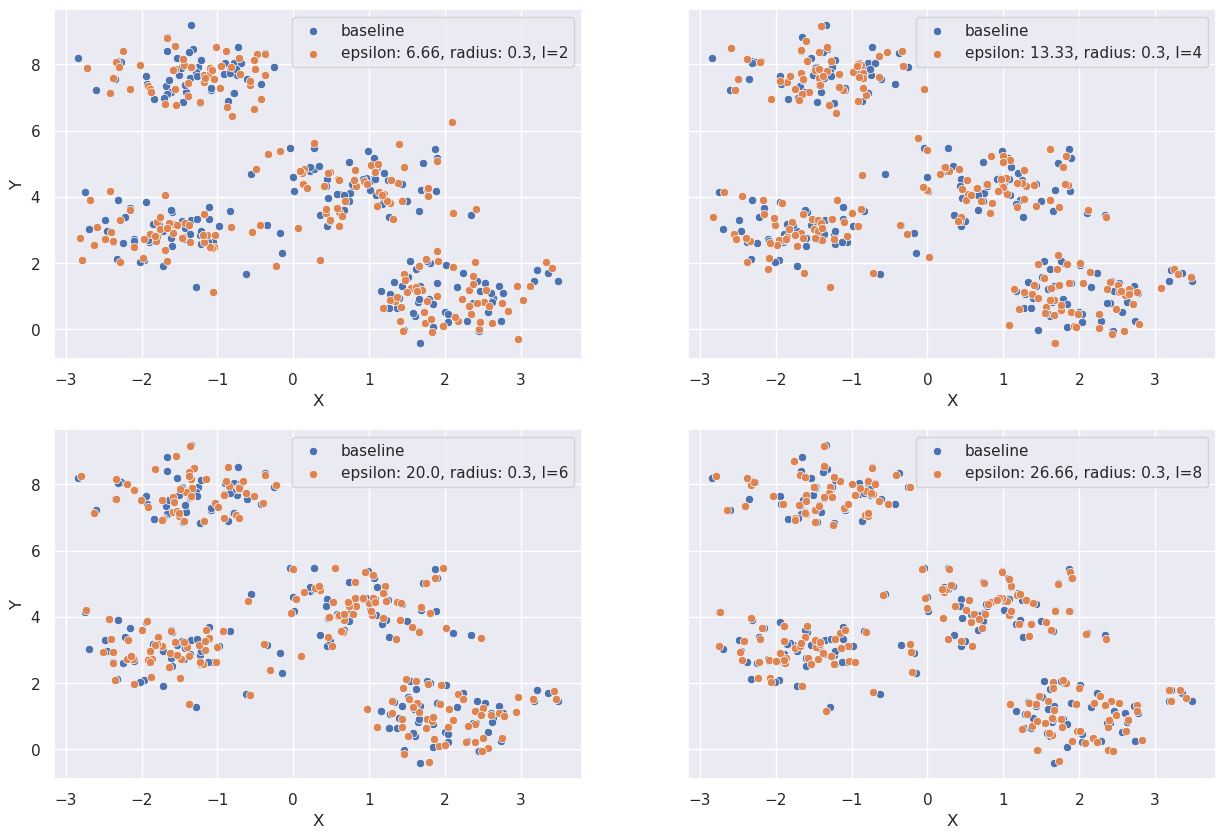

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
sns.scatterplot(data=df, x='X', y='Y', ax=axes[0,0], label='baseline')
sns.scatterplot(data=df, x='6_X', y='6_Y', ax=axes[0,0], label='epsilon: 6.66, radius: 0.3, l=2')

sns.scatterplot(data=df, x='X', y='Y', ax=axes[0,1], label='baseline')
sns.scatterplot(data=df, x='13_X', y='13_Y', ax=axes[0,1], label='epsilon: 13.33, radius: 0.3, l=4')

sns.scatterplot(data=df, x='X', y='Y', ax=axes[1,0], label='baseline')
sns.scatterplot(data=df, x='20_X', y='20_Y', ax=axes[1,0], label='epsilon: 20.0, radius: 0.3, l=6')

sns.scatterplot(data=df, x='X', y='Y', ax=axes[1,1], label='baseline')
sns.scatterplot(data=df, x='26_X', y='26_Y', ax=axes[1,1], label='epsilon: 26.66, radius: 0.3, l=8')


So logically, a higher privacy level $l$, yields less accurate results; but provides more privacy. 

## Clustering
Based on the results it is notably visible that $r=0.3$, $l=4$ and $\epsilon=13.33$ has a very high similarity to the original data. A little to high regarding the trade-off between utillity and privacy. It is also worth to mention that the last two scatterplots seem to much off. Therefore, based on visual inspection the second one has a good utillity / privacy trade-off.
- r = 0.3
- l = 13.33
- epsilon = l\r 

In [8]:
r = 0.3
l = 4
epsilon = l/r
epsilon

13.333333333333334

In [9]:
df2 = df.loc[:, ['X', 'Y', '13_X', '13_Y']]
df2.head()

,X,Y,13_X,13_Y
0,2.234210,1.693495,2.138111,1.722361
1,-1.055107,2.638031,-1.059342,2.801919
2,1.082726,4.062719,1.047235,4.078541
3,-2.601594,7.221956,-2.537017,7.229914
4,1.608415,0.401801,1.557682,0.672597


### Preprocessing
For the actual clustering we need a pre-processing stap which is scaling (to make sure the data is on the same scale)

In [10]:
from sklearn.preprocessing import StandardScaler

plainDf = df2.loc[:, ['X', 'Y']]
plainDf_scaled = pd.DataFrame(StandardScaler().fit_transform(plainDf), columns=['X', 'Y'])

perturbedDf = df2.loc[:, ['13_X', '13_Y']]
perturbedDf_scaled = pd.DataFrame(StandardScaler().fit_transform(perturbedDf), columns=['X', 'Y'])

### K-means

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


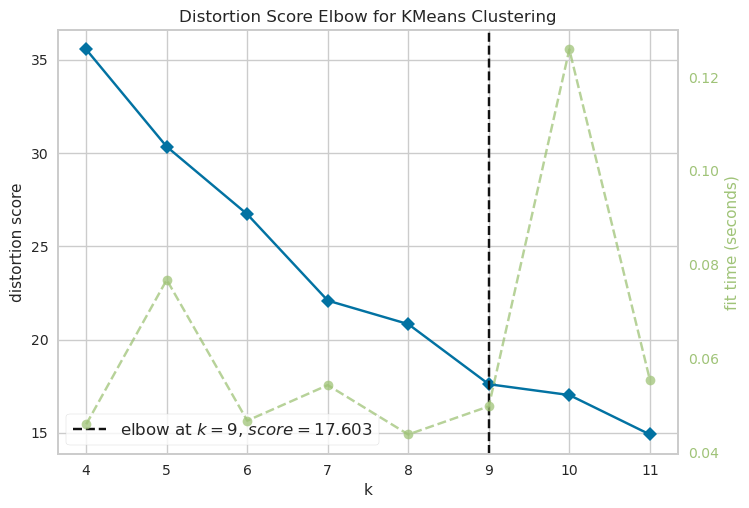

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans(init='random')
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(plainDf_scaled.loc[:, ['X', 'Y']])        # Fit the data to the visualizer
visualizer.show()

In [12]:
from sklearn.cluster import KMeans

n_clusters = visualizer.elbow_value_ # as determined using a elbowplot

def calculate_kmeans(df): 
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init="random")
    y_kmeans = kmeans.fit(df)
    return y_kmeans
    
def plot_kmeans(df, fitted_algo, ax):
    labels = fitted_algo.labels_
    centroids = fitted_algo.cluster_centers_ if hasattr(fitted_algo, 'cluster_centers_') else df.groupby(labels).mean().to_numpy()
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:,1], ax=ax, hue=labels)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], ax=ax, s=100)
    #centers.iloc[:, 0], centers.iloc[:, 1]
def plot_algorithm (plainDf, perturbedDf, algorithmPlain, algorithmPerturbed,algorithmName): 
    fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle('%s (r=%.2f, l=%.2f, $\epsilon$=l/r=%d)' % (algorithmName, r, l,epsilon))
    axes[0].set_title('Plain data')
    plot_kmeans(plainDf,algorithmPlain, axes[0])
    axes[1].set_title('Perturbed data')
    plot_kmeans(perturbedDf,algorithmPerturbed, axes[1])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


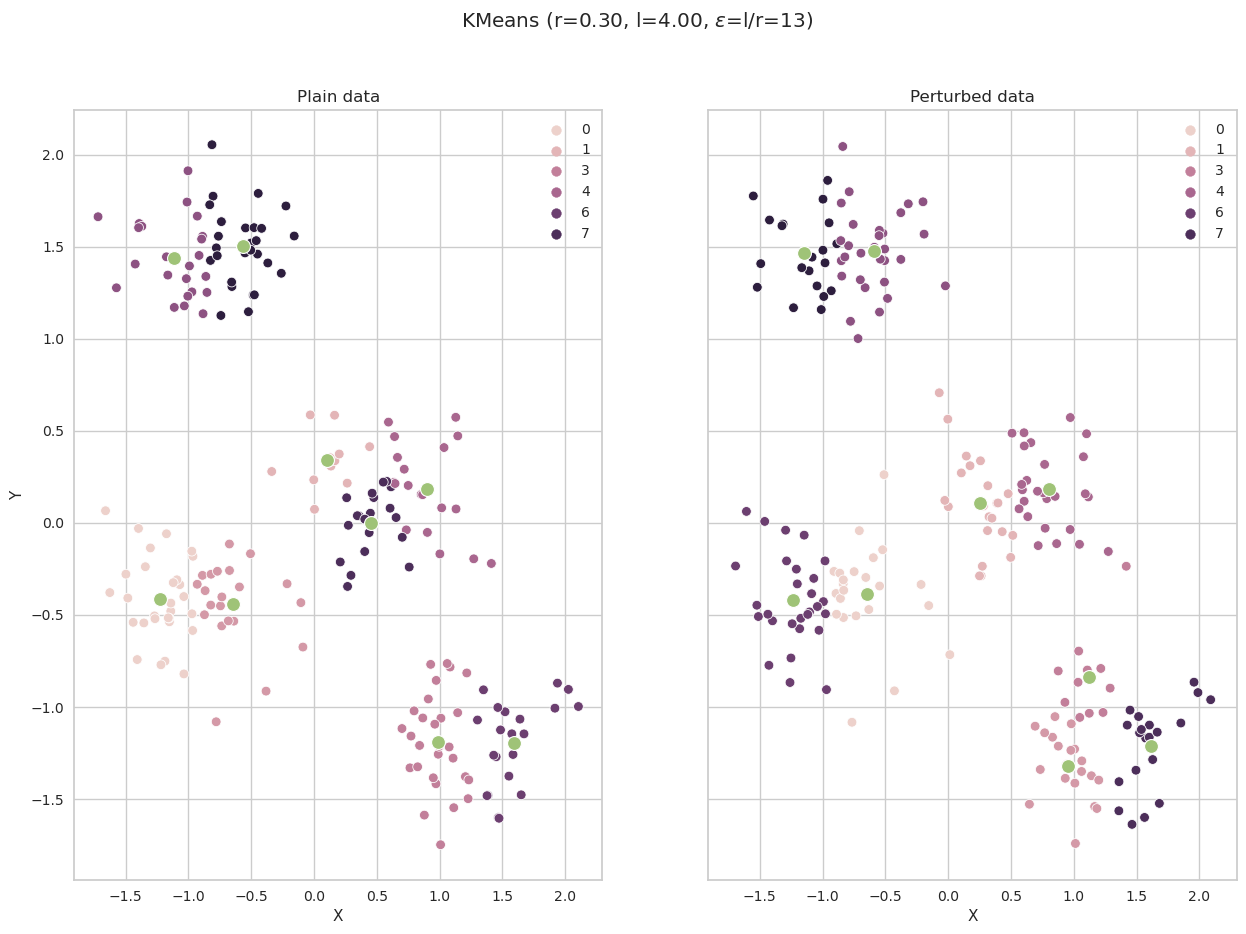

In [13]:
kmeans_fitted_plain = calculate_kmeans(plainDf_scaled)
kmeans_fitted_perturbed = calculate_kmeans(perturbedDf_scaled)
plot_algorithm(plainDf_scaled, perturbedDf_scaled, kmeans_fitted_plain, kmeans_fitted_perturbed, 'KMeans')

### Affinity propagation

In [14]:
from sklearn.cluster import AffinityPropagation

def fit_ap(dataframe):
    ap = AffinityPropagation(affinity='euclidean', random_state=0).fit(dataframe)
    return ap

def scatter_ap(dataframe, fitted_ap, ax): 
    centroids = fitted_ap.cluster_centers_
    labels =fitted_ap.labels_
    sns.scatterplot(x=dataframe.iloc[:, 0], y=dataframe.iloc[:,1], ax=ax, hue=labels)
    sns.scatterplot(centroids[:, 0], centroids[:, 1], s=100, ax=ax)

def ap_and_plot(df): 
    fitted_ap = fit_ap(df)
    scatter_ap(df, fitted_ap)

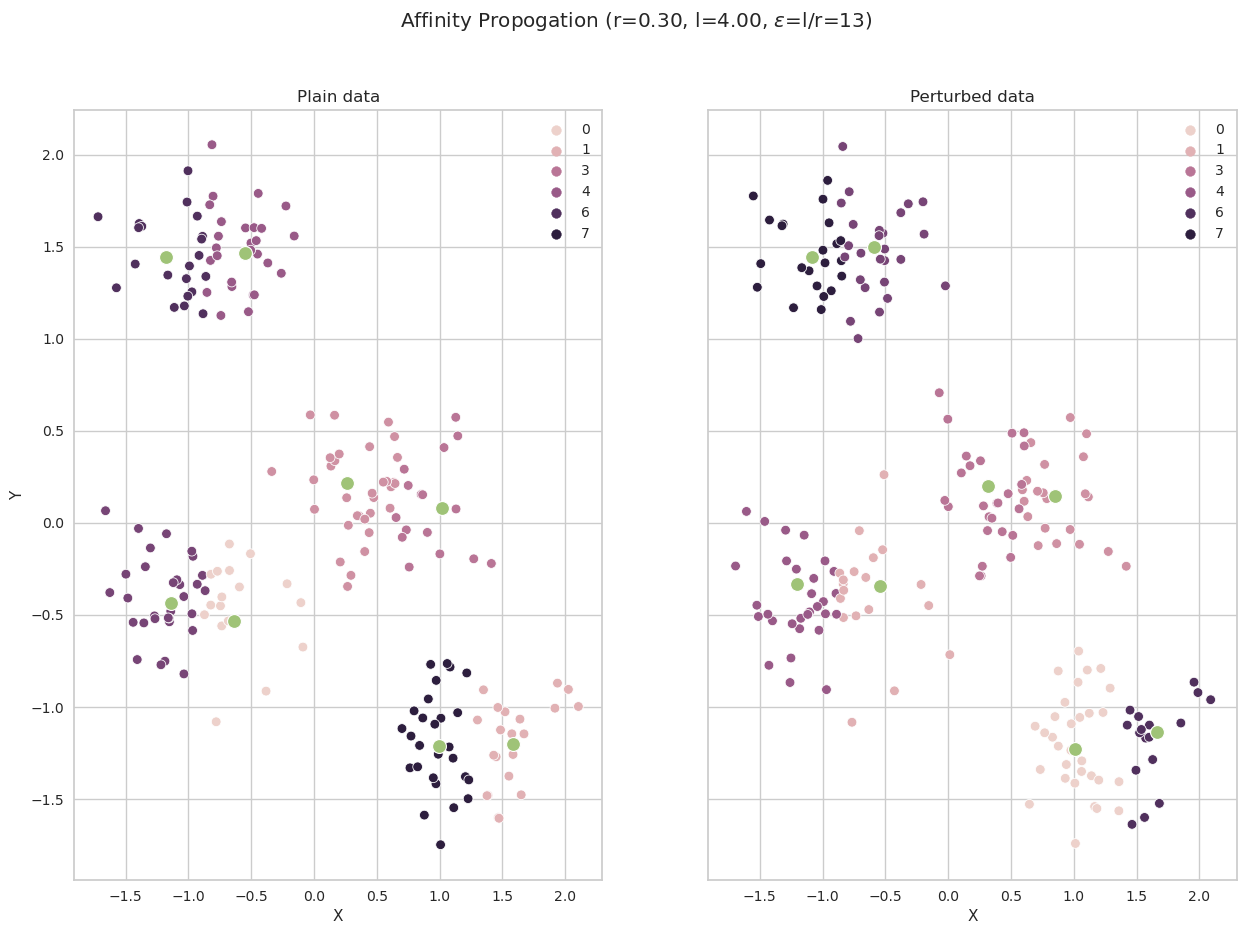

In [15]:
# fig.suptitle('Affinity Propogation (r=%.2f, l=%.2f, $\epsilon$=l/r=%d)' % (r, l,epsilon))
fitted_ap_plain = fit_ap(plainDf_scaled)
fitted_ap_perturbed = fit_ap(perturbedDf_scaled)

plot_algorithm(plainDf_scaled, perturbedDf_scaled, fitted_ap_plain, fitted_ap_perturbed, 'Affinity Propogation')

### DBSCAN

In [16]:
from sklearn.cluster import DBSCAN


def fit_dbscan(df):
    dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
    dbscan.fit(df)

    labels = dbscan.labels_
    centers = df.groupby(labels).mean()
    return dbscan

def scatter_dbscan(df, labels, centers): 
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:,1],hue=labels)
    plt.scatter(centers.iloc[:, 0], centers.iloc[:, 1], s=100, c='r')
    plt.show()


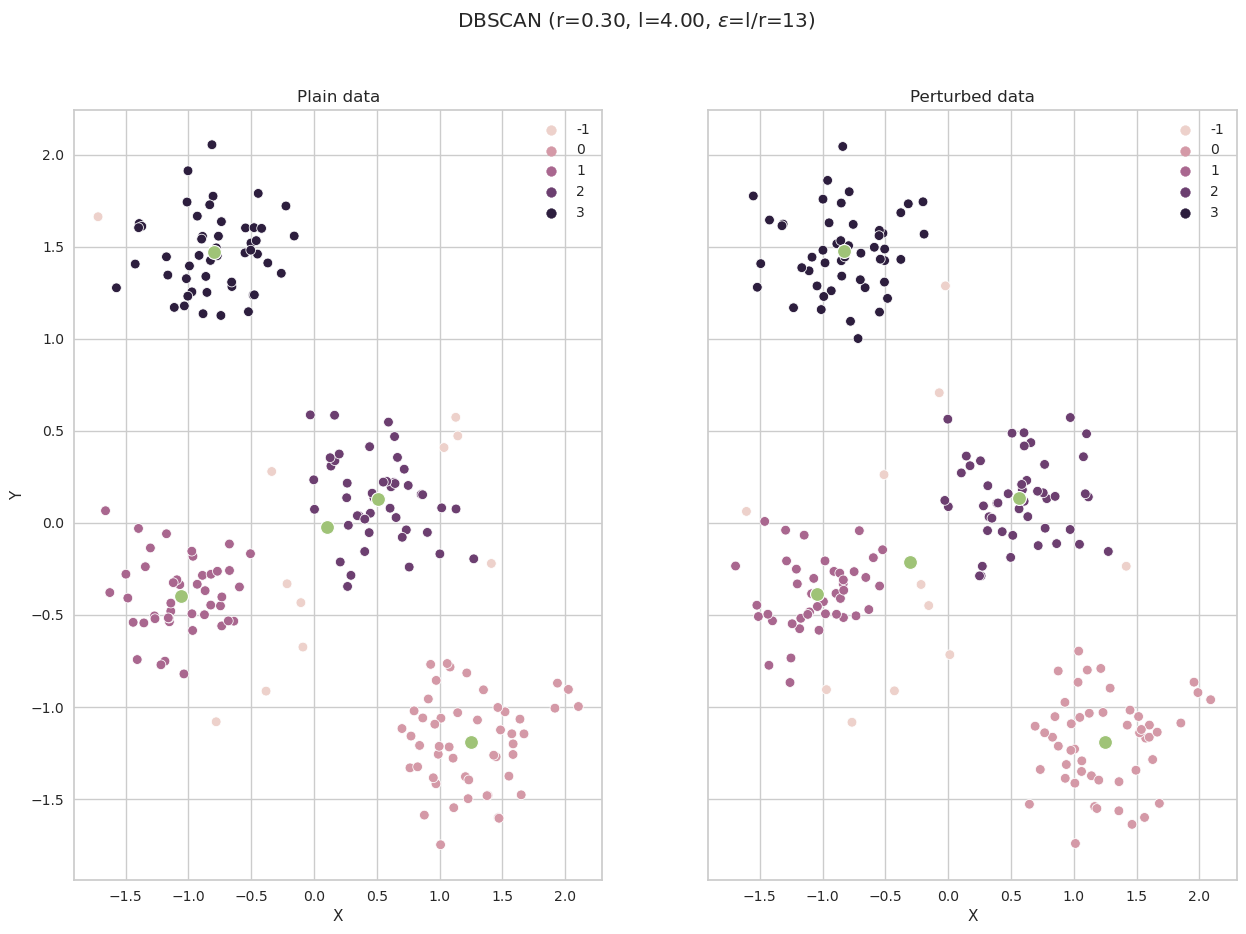

In [17]:
dbscan_fitted_plain = fit_dbscan(plainDf_scaled)
dbscan_fitted_perturbed = fit_dbscan(perturbedDf_scaled)

plot_algorithm(plainDf_scaled, perturbedDf_scaled, dbscan_fitted_plain, dbscan_fitted_perturbed, 'DBSCAN')

## Measurement

It is often hard to evaluate the performance of clustering by the human eye.
Therefore, we will use a metric to evaluate cluster performance between baseline and perturbed clustering.
To this end we compare these two using a silhouette coefficient.
- For silhouette score higher is better (The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster) See: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


In [18]:
from sklearn import metrics

## KMeans
metrics_kmeans_silhouette_score_plain = metrics.silhouette_score(plainDf, kmeans_fitted_plain.labels_, metric='euclidean')
metrics_kmeans_silhouette_score_perturbed = metrics.silhouette_score(perturbedDf, kmeans_fitted_perturbed.labels_, metric='euclidean')

# AP
metrics_ap_silhouette_score_plain = metrics.silhouette_score(plainDf, fitted_ap_plain.labels_, metric='euclidean')
metrics_ap_silhouette_score_perturbed = metrics.silhouette_score(perturbedDf, fitted_ap_perturbed.labels_, metric='euclidean')

# DBSCAN
#metrics_dbscan_silhouette_score_plain = metrics.silhouette_score(plainDf, dbscan_fitted_plain, metric='euclidean')
#metrics_dbscan_silhouette_score_perturbed = metrics.silhouette_score(perturbedDf, dbscan_fitted_perturbed, metric='euclidean')


In [19]:
print(metrics_kmeans_silhouette_score_plain, metrics_kmeans_silhouette_score_perturbed, metrics_kmeans_silhouette_score_plain - metrics_kmeans_silhouette_score_perturbed)
print(metrics_ap_silhouette_score_plain, metrics_ap_silhouette_score_perturbed, metrics_ap_silhouette_score_plain - metrics_ap_silhouette_score_perturbed)
#print(metrics_dbscan_silhouette_score_plain, metrics_dbscan_silhouette_score_perturbed, metrics_dbscan_silhouette_score_plain - metrics_dbscan_silhouette_score_perturbed)

0.30692833543329756 0.30838090660018236 -0.0014525711668847974
0.3076349170369161 0.2955790355074223 0.012055881529493773


In [20]:
metrics_kmeans_ci_score_plain = metrics.calinski_harabasz_score(plainDf, kmeans_fitted_plain.labels_)
metrics_kmeans_ci_perturbed = metrics.calinski_harabasz_score(perturbedDf, kmeans_fitted_perturbed.labels_)


In [21]:
print(metrics_kmeans_ci_score_plain, metrics_kmeans_ci_perturbed, metrics_kmeans_ci_score_plain - metrics_kmeans_ci_perturbed)


505.8113063161804 475.6275408304771 30.183765485703304


### Evaluation of different privacy levels for each model


In [22]:
radius = 2
levels = [2, 3, 4, 5, 6, 7, 8]
epsilons = [l/radius for l in levels]
epsilons

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

In [23]:
# Adjusted Mutual Information Index
from sklearn.metrics import adjusted_mutual_info_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate

def calculate_anmi(dataset, baseline_dataset, algorithm): 
    
    model = algorithm.fit(dataset)
    labels1 = model.labels_
    model2 = algorithm.fit(baseline_dataset)
    labels2 = model2.labels_
    #y_predict = model.labels_ 
   # scores = cross_val_score(algorithm, X, y, scoring='silhouette_score', cv=cv, n_jobs=-1,  metric='euclidean')
    nmi = metrics.adjusted_mutual_info_score(labels1, labels2)
    print(nmi)
    return nmi

def calculate_ami_for_plain_perturbed(dataset1, dataset2, model):
    return calculate_anmi(dataset1, model), calculate_anmi(dataset2, model)
        
def validate_multiple_times(n_times, dataset, algorithm): 
    scores = []
    for i in range(n_times):
        print(calculate_anmi(dataset, algorithm))
        scores.append(calculate_anmi(dataset, algorithm))
    
    return np.mean(scores)

def calculate_models_for_epsilons(X, models, epsilons):
    dict = {}
    plainScore = {}
    df1 = pd.DataFrame()
    df1['X'] = X[:, 0]
    df1['Y'] = X[:, 1]
    plainDf_scaled = pd.DataFrame(StandardScaler().fit_transform(df1), columns=['X', 'Y'])
    for model in models:
        df2 = pd.DataFrame()
        dict[model.__class__.__name__] = []
        #nmi1 = calculate_anmi(plainDf_scaled, model)
        #plainScore[model.__class__.__name__] = nmi1
        for i in range(len(epsilons)):
            eps = epsilons[i]
            x_max, x_min, Z = generate_truncated_laplace_noise(X, eps)
            Z = np.array(Z)
            df2['X'] = Z[:, 0]
            df2['Y'] = Z[:, 1]
            perturbedDf_scaled = pd.DataFrame(StandardScaler().fit_transform(df2), columns=['X', 'Y'])

            nmi2 = calculate_anmi(perturbedDf_scaled, plainDf_scaled, model)
            dict[model.__class__.__name__].append(nmi2)

    return dict

In [24]:
class DbScanWrapper(DBSCAN):
    def predict(self,X):
      return self.labels_


kmeans = KMeans(n_clusters=n_clusters, init="random")
ap = AffinityPropagation(affinity='euclidean');
dbscan = DbScanWrapper(eps=0.3, min_samples=5, metric='euclidean')



In [25]:
perturbedScores = calculate_models_for_epsilons(X, [kmeans, ap, dbscan], epsilons)
KMeansScores = pd.DataFrame()
KMeansScores['scores'] = perturbedScores['KMeans']
KMeansScores['epsilons'] = epsilons
KMeansScores['type'] = 'KMeans'
AffinityScores = pd.DataFrame()
AffinityScores['scores'] = perturbedScores['AffinityPropagation']
AffinityScores['epsilons'] = epsilons
AffinityScores['type'] = 'Affinity propagation'
DbscanScores = pd.DataFrame()
DbscanScores['scores'] = perturbedScores['DbScanWrapper']
DbscanScores['epsilons'] = epsilons
DbscanScores['type'] = 'DBSCAN'
scoresPd = pd.concat([KMeansScores, AffinityScores, DbscanScores], ignore_index=True)
scoresPd

0.3126619651146632
0.40365705691238263
0.5638323538486113
0.5910758215114725
0.665162365022589
0.66523589145394
0.6844064320865136
0.3091312451622899
0.4175924917767413
0.49178058671833214
0.6049619229673869
0.5953238774140359
0.6741001915507633
0.7183590062815285
0.257133093072183
0.381566988059537
0.5740691888285558
0.39847205636554117
0.7675761440031247
0.8243636378907784
0.8287219929878973


,scores,epsilons,type
0,0.312662,1.0,KMeans
1,0.403657,1.5,KMeans
2,0.563832,2.0,KMeans
3,0.591076,2.5,KMeans
4,0.665162,3.0,KMeans
5,0.665236,3.5,KMeans
6,0.684406,4.0,KMeans
7,0.309131,1.0,Affinity propagation
8,0.417592,1.5,Affinity propagation
9,0.491781,2.0,Affinity propagation


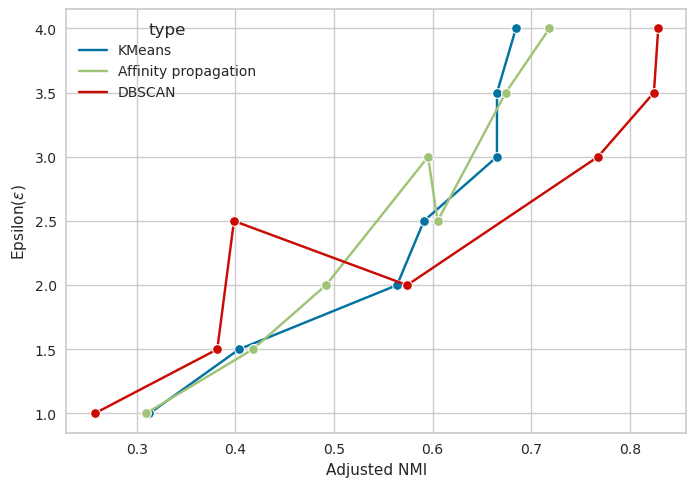

In [26]:
ax = sns.lineplot(data=scoresPd, x="scores", y="epsilons", hue='type', marker='o', markers=True,sort=True)
ax.set(xlabel='Adjusted NMI', ylabel='Epsilon($\epsilon$)')
plt.show()